<a href="https://colab.research.google.com/github/linhoangce/pytorch_crash_course/blob/main/classification_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
!pip install torchmetrics

In [3]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

### 1. Make a binary classification dataset with Scikit-Learn's make-moons() function.

In [4]:
SAMPLES = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples=SAMPLES,
                  noise=0.07,
                  random_state=RANDOM_SEED)
X[:5], y[:5]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483]]),
 array([1, 1, 1, 1, 0]))

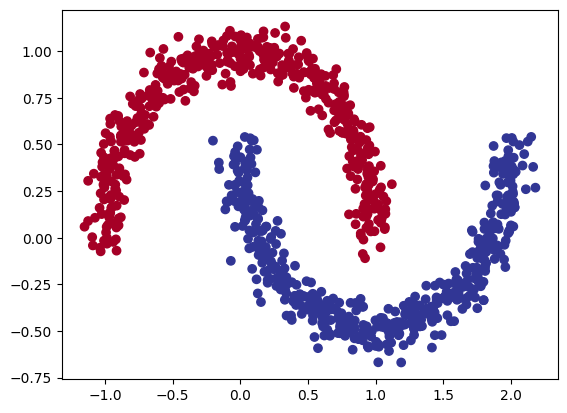

In [5]:
plt.scatter(X[:, 0], X[:, 1],
            c=y, cmap=plt.cm.RdYlBu);

In [6]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

X_train[:5], y_train[:5]

(tensor([[ 2.0144,  0.2466],
         [-1.0187,  0.4045],
         [-0.1252,  1.0580],
         [-0.0977,  0.9901],
         [ 0.3807, -0.2384]]),
 tensor([1., 0., 0., 0., 1.]))

In [7]:
len(X), len(y)

(1000, 1000)

In [8]:
len(X_train), len(y_train)

(800, 800)

### 2. Build model

In [9]:
class MoonModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_neurons):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features,
                  out_features=hidden_neurons),
        nn.ReLU(),
        nn.Linear(in_features=hidden_neurons,
                  out_features=hidden_neurons),
        nn.ReLU(),
        nn.Linear(in_features=hidden_neurons,
                  out_features=out_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model = MoonModel(in_features=2,
                  out_features=1,
                  hidden_neurons=10).to(device)
model

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [10]:
next(model.parameters()).device

device(type='cuda', index=0)

### 3. Loss function and optimizer

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

### 4. Train and test loop

In [12]:
# accuracy object
import torchmetrics

accuracy = torchmetrics.Accuracy(task='multiclass',
                                 num_classes=2).to(device)
accuracy

MulticlassAccuracy()

In [13]:
torch.manual_seed(RANDOM_SEED)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_pred, y_train.int())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy(test_pred, y_test.int())

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69560, Acc: 0.50 | Test Loss: 0.69894, Test Acc: 0.50
Epoch: 100 | Loss: 0.46864, Acc: 0.80 | Test Loss: 0.48708, Test Acc: 0.78
Epoch: 200 | Loss: 0.32276, Acc: 0.87 | Test Loss: 0.33003, Test Acc: 0.88
Epoch: 300 | Loss: 0.26794, Acc: 0.89 | Test Loss: 0.26622, Test Acc: 0.90
Epoch: 400 | Loss: 0.23484, Acc: 0.90 | Test Loss: 0.22990, Test Acc: 0.92
Epoch: 500 | Loss: 0.20264, Acc: 0.92 | Test Loss: 0.19522, Test Acc: 0.93
Epoch: 600 | Loss: 0.16343, Acc: 0.94 | Test Loss: 0.15396, Test Acc: 0.95
Epoch: 700 | Loss: 0.11939, Acc: 0.96 | Test Loss: 0.10935, Test Acc: 0.98
Epoch: 800 | Loss: 0.08126, Acc: 0.99 | Test Loss: 0.07278, Test Acc: 0.99
Epoch: 900 | Loss: 0.05584, Acc: 0.99 | Test Loss: 0.04886, Test Acc: 1.00


### 5. Make predictions and plot the graph

In [14]:
import numpy as np

In [36]:
def plot_decision_boundary(model, X, y):

  # put everything to CPU as data can come from gpu
  model.to("cpu")
  X, y = X.to("cpu"), y.to("cpu")

  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                       np.linspace(y_min, y_max, 101))

  # Make features
  X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(),
                                                   yy.ravel()))).float()

  # make predictions
  model.eval()
  with torch.inference_mode():
    y_logits = model(X_to_pred_on)

  # Test for multi-class or binary and adjust logits to prediction labels
  if len(torch.unique(y)) > 2:
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # multiclass
  else:
    y_pred = torch.round(torch.sigmoid(y_logits)) # binary

  # reshape preds and plot
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  plt.contourf(xx, yy, y_pred,
              cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1],
              c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())


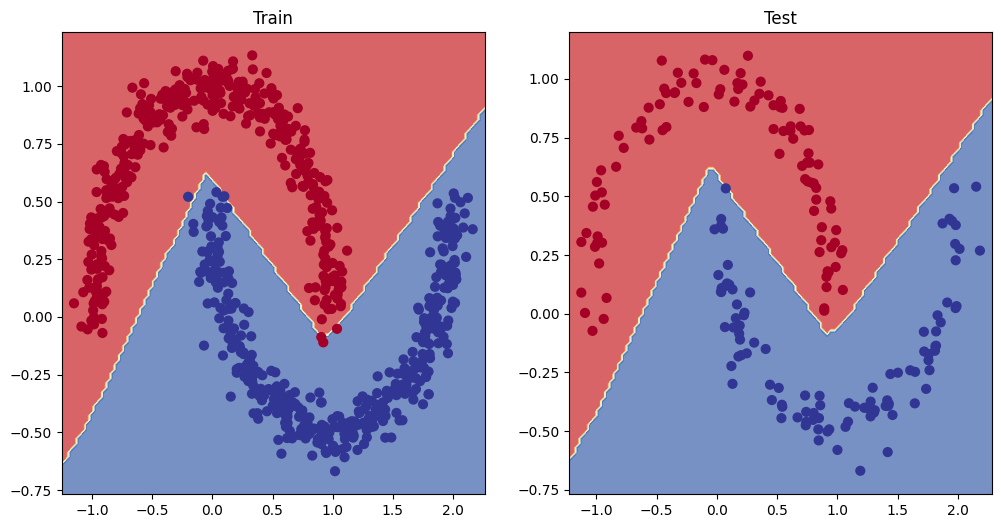

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

### 6. Tanh activation

In [17]:
def tanh(x):
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

tanh(X_train)

tensor([[ 0.9650,  0.2417],
        [-0.7693,  0.3838],
        [-0.1245,  0.7849],
        ...,
        [-0.6497,  0.5501],
        [ 0.7816,  0.1165],
        [ 0.9587,  0.1256]], device='cuda:0')

### 7. Create a multi-class dataset using the spirals data creation function from Stanford CS231n

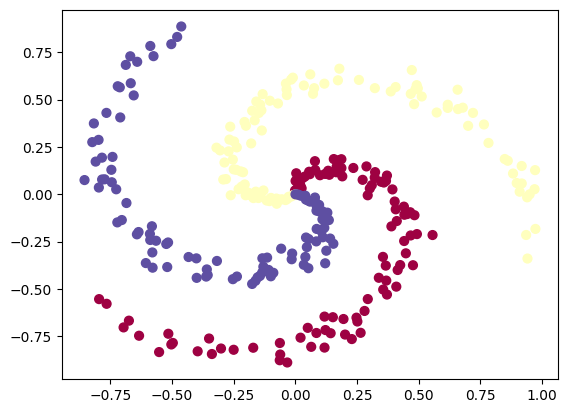

In [18]:
# Spiral dataset from CS231n
import numpy as np

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K, D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
  ix = range(N*j, N*(j+1))
  r = np.linspace(0.0, 1, N) # radius
  t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# visualize the data
plt.scatter(X[:, 0], X[:, 1],
            c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [19]:
X.shape

(300, 2)

In [20]:
X[:10], y[:10]

(array([[-0.        ,  0.        ],
        [ 0.0032371 ,  0.00956826],
        [-0.00186262,  0.02011597],
        [ 0.00644886,  0.02960888],
        [ 0.0249365 ,  0.03179084],
        [ 0.01992087,  0.04641033],
        [ 0.01705905,  0.05815568],
        [ 0.00051708,  0.07070518],
        [ 0.00947975,  0.08025011],
        [ 0.0293483 ,  0.0860415 ]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [21]:
# model
class SpiralModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_neurons):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features,out_features=hidden_neurons),
        nn.ReLU(),
        nn.Linear(in_features=hidden_neurons, out_features=hidden_neurons),
        nn.ReLU(),
        nn.Linear(in_features=hidden_neurons, out_features=hidden_neurons),
        nn.ReLU(),
        nn.Linear(in_features=hidden_neurons, out_features=out_features)
    )

  def forward(self, x):
    return self.layer_stack(x)

model_1 = SpiralModel(in_features=2,
                      out_features=3,
                      hidden_neurons=10).to(device)
model_1

SpiralModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [22]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [23]:
# turn data into tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# split data into training and test sets
X_train_spiral, X_test_spiral, y_train_spiral, y_test_spiral = train_test_split(X, y,
                                                                                test_size=0.2,
                                                                                random_state=RANDOM_SEED)
len(X_train_spiral), len(X_test_spiral)

(240, 60)

In [24]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.01)
accuracy = torchmetrics.Accuracy(task='multiclass',
                                 num_classes=3).to(device)

In [25]:
# put data to device
X_train_spiral, y_train_spiral = X_train_spiral.to(device), y_train_spiral.to(device)
X_test_spiral, y_test_spiral = X_test_spiral.to(device), y_test_spiral.to(device)

epochs = 1000

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train_spiral)
  y_probs = torch.softmax(y_logits, dim=1)
  y_pred = torch.argmax(y_probs, dim=1)

  loss = loss_fn(y_logits, y_train_spiral)
  acc = accuracy(y_pred, y_train_spiral)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Test
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test_spiral)
    test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
    test_loss = loss_fn(test_logits, y_test_spiral)
    test_acc = accuracy(test_pred, y_test_spiral)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.10378, Acc: 0.32 | Test Loss: 1.09075, Test Acc: 0.37
Epoch: 100 | Loss: 0.52355, Acc: 0.73 | Test Loss: 0.61129, Test Acc: 0.62
Epoch: 200 | Loss: 0.18743, Acc: 0.93 | Test Loss: 0.20087, Test Acc: 0.92
Epoch: 300 | Loss: 0.04695, Acc: 0.99 | Test Loss: 0.02430, Test Acc: 1.00
Epoch: 400 | Loss: 0.02995, Acc: 0.99 | Test Loss: 0.00847, Test Acc: 1.00
Epoch: 500 | Loss: 0.02434, Acc: 0.99 | Test Loss: 0.00425, Test Acc: 1.00
Epoch: 600 | Loss: 0.02175, Acc: 0.99 | Test Loss: 0.00516, Test Acc: 1.00
Epoch: 700 | Loss: 0.01926, Acc: 0.99 | Test Loss: 0.01240, Test Acc: 1.00
Epoch: 800 | Loss: 0.01786, Acc: 0.99 | Test Loss: 0.02464, Test Acc: 0.98
Epoch: 900 | Loss: 0.01689, Acc: 0.99 | Test Loss: 0.03740, Test Acc: 0.98


In [26]:
# Evaluate
model_1.eval()
with torch.inference_mode():
  test_logits = model_1(X_test_spiral)
  test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

test_pred[:10], y_test_spiral[:10]

(tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1], device='cuda:0'),
 tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1], device='cuda:0'))

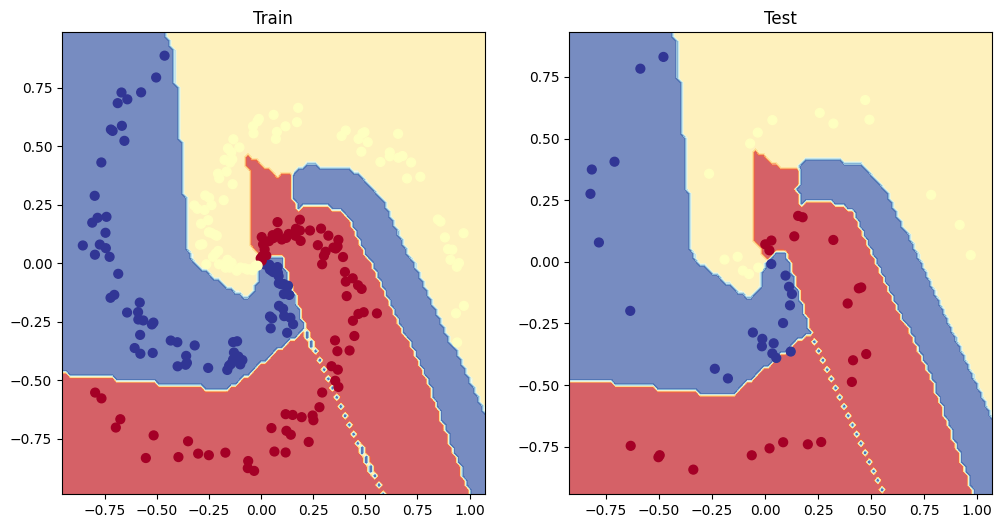

In [38]:
# visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train_spiral.cpu(), y_train_spiral.cpu())
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test_spiral.cpu(), y_test_spiral.cpu())

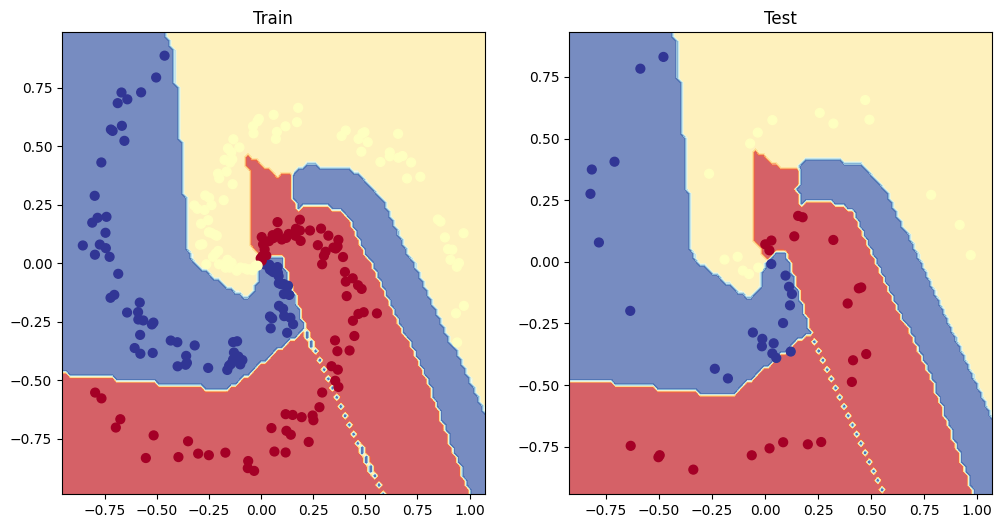